In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/.conda/envs/psps2/bin/python
farshed.abdukhakimov
cn-08
/home/farshed.abdukhakimov/projects/psps2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from torch.optim import SGD, Adam

from momo import Momo

import matplotlib.pyplot as plt

import experiments.loss_functions as lf
import experiments.datasets as datasets 
import experiments.models as models

torch.set_default_dtype(torch.float64)

%load_ext line_profiler

/home/farshed.abdukhakimov/.conda/envs/psps2/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/farshed.abdukhakimov/.conda/envs/psps2/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/farshed.abdukhakimov/.conda/envs/psps2/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cpu')

In [5]:
batch_size = 512
train_loader, test_loader = datasets.get_MNIST(batch_size=batch_size, percentage=0.2)

In [6]:
model = models.LeNet5(num_classes=10)
print(model)
for images, labels in test_loader:
    outputs = model(images)
    print(outputs[0])
    print(labels[0])
    break

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
tensor([ 0.0323, -0.1389, -0.0531, -0.0357, -0.0653, -0.0432, -0.0047,  0.0217,
         0.0593,  0.0316], grad_fn=<SelectBackward0>)
tensor(1)


In [7]:
model = models.NN(num_classes=10)
w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print ("Total parameters",d)  

Total parameters 109386


In [8]:
lenet = models.LeNet5(num_classes=10)
w0 = [w+0.0 for w in lenet.parameters()]
d = np.sum([w.numel() for w in lenet.parameters()])
print ("Total parameters",d)  

Total parameters 61706


In [9]:
class PSPS2(torch.optim.Optimizer):

    def __init__(
            self, 
            params, 
            preconditioner="none",
            lmd=0.01, 
            mu=0.1,
            eps=1e-8):
        
        defaults = dict(lmd=lmd, mu=mu, eps=eps)


        super().__init__(params, defaults)


        if preconditioner == "hessian":
            self._update_precond_grad = self._update_precond_grad_cg
        elif preconditioner == "adam":
            self._update_precond_grad = self._update_precond_grad_adam
            for group in self.param_groups:
                for p in group["params"]:
                    self.state[p]["adam_v"] = torch.zeros_like(p)
        elif preconditioner == "adagrad":
            self._update_precond_grad = self._update_precond_grad_adagrad
            for group in self.param_groups:
                for p in group["params"]:
                    self.state[p]["adagrad_v"] = torch.zeros_like(p)


        elif preconditioner == "none":
            self._update_precond_grad = self._update_precond_grad_identity


        # TO-DO: Think of something better
        self.replay_buffer = []

        self.step_t = 0


        

    def step(self, closure=None):
        
        loss = None 
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        self.step_t += 1
        self._update_precond_grad()
        self.update(loss=loss)


        # self.replay_buffer.append({
        #         "loss": loss,
        #         "grad_norm_sq": gnorm_square,
        #         "slack": group['s'],
        #         "step_size": group["step_size"],
        #     }) 
            
                          
        return loss 

    def update(self, loss):
        for group in self.param_groups: 
            for p in group['params']:
                precond_grad = self.state[p]["precond_grad"]
                print(p.grad.shape, precond_grad.shape)
                grad_norm_sq = torch.dot(p.grad, precond_grad)
                eps = group['eps']
                if 2 * loss <= grad_norm_sq:    
                    det = 1 - 2 * (loss / (grad_norm_sq + eps))
                    if det < 0.0:
                        group["step_size"] = 1.0
                    else:
                        group["step_size"] = 1 - torch.sqrt(det).item()
                else:
                    group["step_size"] = 1.0
                
                with torch.no_grad():
                    p.sub_(precond_grad, alpha=group['step_size'])

    def _update_precond_grad_identity(self):
        for group in self.param_groups:
            for p in group["params"]:
                self.state[p]["precond_grad"] = p.grad


    def _update_precond_grad_adam(self):
        betas = (0.9, 0.999)
        for group in self.param_groups:
            for p in group["params"]:
                with torch.no_grad():
                    self.state[p]["adam_v"] = betas[1] * self.state[p]["adam_v"] + (1 - betas[1]) * torch.square(p.grad)
                    v_hat = self.state[p]["adam_v"] / (1 - betas[1]**self.step_t)
                    precond = 1 / (torch.sqrt(v_hat) + 1e-8)
                    self.state[p]["precond_grad"] = precond * p.grad

    def _update_precond_grad_adagrad(self):
        for group in self.param_groups:
            for p in group["params"]:
                with torch.no_grad():
                    self.state[p]["adagrad_v"] = self.state[p]["adagrad_v"] + torch.square(p.grad)
                    precond = 1 / (torch.sqrt( self.state[p]["adagrad_v"]) + 1e-10)
                    self.state[p]["precond_grad"] = precond * p.grad
        

    def _update_precond_grad_cg(self):
        for group in self.param_groups: 
            for p in group["params"]:
                print(p.shape)
                s = torch.zeros_like(p) # s = H_inv * grad
                r = p.grad.detach().clone()
                d = r.detach().clone()
                r_prev = torch.dot(r, r)
                MAX_ITER = 1000

                for cg_step in range(MAX_ITER):
                    hvp = torch.autograd.grad(p.grad, p, grad_outputs=d, retain_graph=True)[0]
                    alpha_k = torch.dot(r, r) / torch.dot(d, hvp)
                    s = s + alpha_k * d
                    r_prev = r.detach().clone()
                    r = r - alpha_k * hvp
                    if torch.norm(r) < 1e-2:
                        break
                        
                    beta_k = torch.dot(r, r) / torch.dot(r_prev, r_prev)
                    d = r + beta_k * d
                print(cg_step)
                self.state[p]["precond_grad"] = s


    def _update_precond(self):
        for group in self.param_groups:
            for p in group['params']:
                if not self.preconditioner.initialized:
                    self.state[p]['precond_mx'] = self.preconditioner.init(p)
                self.state[p]['precond_mx'] = self.preconditioner.step(p)

    def _init_empty_precond(self):
        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['precond_mx'] = torch.ones_like(p) 

    @torch.no_grad()
    def _get_grad_norm_sq(self):
        for group in self.param_groups: 
            grad_norm_sq = torch.tensor(0.)
            for p in group['params']:
                precond_grad = self.state[p]["precond_grad"]
                grad_norm_sq.add_(precond_grad.mul(p.grad).sum())

        return grad_norm_sq

In [10]:
class Custom(torch.optim.Optimizer):

    def __init__(
            self, 
            params,
            eps=1e-8):
        
        defaults = dict(eps=eps)

        super().__init__(params, defaults)
        
        self._update_precond_grad = self._update_precond_grad_adagrad

        for group in self.param_groups:
            for p in group["params"]:
                self.state[p]["v"] = torch.flatten(torch.zeros_like(p))


        self._step_t = 0
        

    def step(self, closure=None):
        
        loss = None 
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        self._step_t += 1
        self._update_precond_grad()
        self.update(loss=loss)
            
                          
        return loss 

    def update(self, loss):
        for group in self.param_groups: 
            for p in group['params']:
                state = self.state[p]
                precond_grad = state["precond_grad"]
                flat_grad = torch.flatten(p.grad.detach().clone())
                grad_norm_sq = torch.dot(flat_grad, precond_grad)
                eps = group['eps']
                if 2 * loss <= grad_norm_sq:    
                    det = 1 - 2 * (loss / (grad_norm_sq + eps))
                    if det < 0.0:
                        group["step_size"] = 1.0
                    else:
                        group["step_size"] = 1 - torch.sqrt(det).item()
                else:
                    group["step_size"] = 1.0

                # group["step_size"] = 0.1
                with torch.no_grad():
                    p.sub_(precond_grad.view_as(p), alpha=group['step_size'])

    def _update_precond_grad_identity(self):
        for group in self.param_groups:
            for p in group["params"]:
                self.state[p]["precond_grad"] = torch.flatten(p.grad)


    def _update_precond_grad_adagrad(self):
        for group in self.param_groups:
            for p in group["params"]:
                state = self.state[p]
                flat_grad = torch.flatten(p.grad.detach().clone())
                state["v"] = state["v"] + torch.square(flat_grad)
                precond = 1 / (torch.sqrt( state["v"]) + 1e-10)
                state["precond_grad"] = torch.mul(precond, flat_grad)
        


In [11]:
def hvp_from_grad(grads_tuple, list_params, vec_tuple):
    # don't damage grads_tuple. Grads_tuple should be calculated with create_graph=True
    dot = 0.
    for grad, vec in zip(grads_tuple, vec_tuple):
        dot += grad.mul(vec).sum()
    return torch.autograd.grad(dot, list_params, retain_graph=True)[0]


class SP2Plus(torch.optim.Optimizer):

    def __init__(
            self, 
            params,
            lr=1.0,
            eps=1e-8):
        
        defaults = dict(lr=lr, eps=eps)

        self.step_t = 0

        super().__init__(params, defaults)
        
    def step(self, closure=None):
        
        loss = None 
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        self.step_t += 1

        for group in self.param_groups:
            for p in group["params"]:
                eps = group["eps"]
                lr =group["lr"]

                grad = p.grad.detach().clone()
                grad_flat = torch.flatten(p.grad.detach().clone())
                # hgp = torch.autograd.grad(p.grad, p, grad_outputs=p.grad, retain_graph=True)[0]
                hgp = hvp_from_grad(list(p.grad), p, list(p.grad))
                grad_norm_sq = torch.dot(grad_flat, grad_flat)
                polyak = loss / (grad_norm_sq + eps)
                v = grad - (hgp * polyak)
                v_norm_sq = torch.dot(torch.flatten(v), torch.flatten(v))
                step = (polyak * grad) + (0.5 * polyak**2 * (torch.dot(torch.flatten(hgp), grad_flat) / (v_norm_sq + eps )) * v) 
                with torch.no_grad():
                    p.sub_(step, alpha=lr)
                    
                    
        return loss

In [12]:
@torch.no_grad()
def eval_model(model, loss_fn, data_loader):
    n_correct = 0
    n_samples = 0
    loss = 0
    
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss += loss_fn(outputs, labels).item() / len(data_loader)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()  
    
    acc = 100.0 * n_correct / n_samples

    return loss, acc


def train_nn(model, criterion, train_loader, test_loader, epochs, optimizer_class, **optimizer_kwargs):
    
    torch.manual_seed(0)

    optimizer = optimizer_class(model.parameters(), **optimizer_kwargs)

    hist = []

        
    for epoch in range(epochs):
        
        with torch.no_grad():
            train_loss, train_acc = eval_model(model, criterion, train_loader) 
            print(f"[{epoch}] | Train Loss: {train_loss} | Train Acc: {train_acc}")
            test_loss, test_acc = eval_model(model, criterion, test_loader)
            print(f"[{epoch}] | Test Loss: {test_loss} | Test Acc: {test_acc}")
            hist.append([train_loss, train_acc, test_loss, test_acc])

        for i, (images, labels) in enumerate(train_loader):  
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            def closure():
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward(create_graph=True)
                return loss
            
            if isinstance(optimizer, PSPS2 | Momo | Custom | SP2Plus): 
                optimizer.step(closure) 
            else:
                loss = closure()
                optimizer.step()
        
    return hist

model = models.LeNet5(num_classes=10).to(device)

hist_nn = train_nn(
    model, 
    torch.nn.CrossEntropyLoss(),
    # F.nll_loss,
    train_loader,
    test_loader,
    100,
    Adam,
    lr=0.1
)

[0] | Train Loss: 2.304484624159375 | Train Acc: 4.975
[0] | Test Loss: 2.3046098866352738 | Test Acc: 4.33


/home/farshed.abdukhakimov/.conda/envs/psps2/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

In [94]:
for i in range(-11, 2, 2):
    print(10**i)

1e-11
1e-09
1e-07
1e-05
0.001
0.1
10


In [408]:
import torch
from torch.optim import Optimizer

class PSPS(Optimizer):

    def __init__(self, params, eps=1e-8):
        defaults = dict(s=0.0, step_size=0.0, eps=eps)
        
        self.update = self.update_sps

        super().__init__(params, defaults)

        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['D'] = torch.ones_like(p) 


    def step(self, closure=None):
        
        loss = None 
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        gnorm_square = self.calc_grad_norm()
        self.update(gnorm_square, loss)

        return loss

    def update_sps(self, grad_norm_sq, loss):
        for group in self.param_groups: 
            for p in group['params']:
                grad = p.grad.detach().clone()
                state = self.state[p]
                scaled_grad = state["D"].mul(grad)
                grad_norm_sq = torch.dot(grad, scaled_grad)
                group["step_size"] = loss / ( grad_norm_sq + group["eps"] )
                # scaled_grad = state["scaled_grad"]
                with torch.no_grad():
                    # p.sub_(self.state[p]['scaled_grad'].mul(group["step_size"]))
                    p.sub_(scaled_grad.mul(group["step_size"])) 
    

    def calc_grad_norm(self):
        for group in self.param_groups: 
            grad_norm_sq = 0.
            for p in group["params"]:
                grad = p.grad.detach().clone()
                state = self.state[p]
                state["scaled_grad"] = state["D"].mul(grad)
                grad_norm_sq += state["scaled_grad"].mul(grad).sum()
        return grad_norm_sq 

In [398]:
import os 
from sklearn.datasets import load_svmlight_file

batch_size = 64
# dataset_name = "covtype.libsvm.binary"
dataset_name = "mushrooms"
percentage = 1.0

EPOCHS = 20
# train_dataloader, train_data, train_target = get_dataset(dataset_name, batch_size, scale_data)
datasets_path = os.getenv("LIBSVM_DIR")
trainX, trainY = load_svmlight_file(f"{datasets_path}/{dataset_name}")
sample = np.random.choice(trainX.shape[0], round(trainX.shape[0] * percentage), replace=False)

assert sample.shape == np.unique(sample).shape

trainX = trainX[sample]
trainY = trainY[sample]

train_data = torch.tensor(trainX.toarray())
train_target = torch.tensor(trainY)


# dataloader
train_load = data_utils.TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=False)


loss_function = lf.logreg
loss_grad = lf.grad_logreg
loss_hessian = lf.hess_logreg

if loss_function == lf.logreg:
    train_target[train_target == train_target.unique()[0]] = torch.tensor(-1.0, dtype=torch.get_default_dtype())
    train_target[train_target == train_target.unique()[1]] = torch.tensor(1.0, dtype=torch.get_default_dtype())
    assert torch.equal(train_target.unique(), torch.tensor([-1.0, 1.0]))

elif loss_function == lf.nllsq:
    train_target[train_target == train_target.unique()[0]] = 0.0
    train_target[train_target == train_target.unique()[1]] = 1.0
    assert torch.equal(train_target.unique(), torch.tensor([0.0, 1.0]))


In [403]:
torch.manual_seed(0)

eps = 1e-8

w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
hist_sps = []

D = torch.ones_like(w)

for epoch in range(EPOCHS):

    loss = loss_function(w, train_data, train_target)
    g, = torch.autograd.grad(loss, w, create_graph=True)
    acc = (np.sign(train_data @ w.detach().numpy()) == train_target).sum() / train_target.shape[0]
    print(f"[{epoch}/{EPOCHS}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()} | Accuracy: {acc}")
    hist_sps.append([loss.item(), (torch.linalg.norm(g) ** 2 ).item(), acc])

    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        loss = loss_function(w, batch_data, batch_target)
        g, = torch.autograd.grad(loss, w, create_graph=True)
        f_grad = g.clone().detach()

        gnorm = torch.dot(f_grad, D.mul(f_grad))
        precond = (loss / (gnorm + eps)) * D
    
        with torch.no_grad():
            w.sub_(precond * f_grad)

[0/20] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/20] | Loss: 0.007636051225941696 | GradNorm^2: 0.00010116575718668257 | Accuracy: 0.9986459871984245
[2/20] | Loss: 0.002573740930363624 | GradNorm^2: 1.2380853962187199e-05 | Accuracy: 0.999015263417036
[3/20] | Loss: 0.0014896136453913216 | GradNorm^2: 9.02964774632995e-06 | Accuracy: 0.9992614475627769
[4/20] | Loss: 0.0006772880842589072 | GradNorm^2: 3.094277104358111e-06 | Accuracy: 0.999507631708518


[5/20] | Loss: 0.00036063304018178906 | GradNorm^2: 1.2013721926028335e-06 | Accuracy: 0.9997538158542589
[6/20] | Loss: 0.0001695396794391308 | GradNorm^2: 3.22626672952995e-07 | Accuracy: 1.0
[7/20] | Loss: 7.200446290450543e-05 | GradNorm^2: 5.2477542567483145e-08 | Accuracy: 1.0
[8/20] | Loss: 3.3534363340521184e-05 | GradNorm^2: 6.309955615483251e-09 | Accuracy: 1.0
[9/20] | Loss: 2.1341405973846813e-05 | GradNorm^2: 1.381072961010789e-09 | Accuracy: 1.0
[10/20] | Loss: 1.6508429142681042e-05 | GradNorm^2: 6.459565972487568e-10 | Accuracy: 1.0
[11/20] | Loss: 1.3462724584202337e-05 | GradNorm^2: 3.1637605507439864e-10 | Accuracy: 1.0
[12/20] | Loss: 1.142634127405103e-05 | GradNorm^2: 1.596857440282289e-10 | Accuracy: 1.0
[13/20] | Loss: 1.0054937487204848e-05 | GradNorm^2: 9.018110639841835e-11 | Accuracy: 1.0
[14/20] | Loss: 9.06080806400804e-06 | GradNorm^2: 5.548313800990377e-11 | Accuracy: 1.0
[15/20] | Loss: 8.301109946302343e-06 | GradNorm^2: 3.641927836374983e-11 | Accurac

In [409]:
torch.manual_seed(0)

# parameters
w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
opt = PSPS([w])

# logging 
hist_psps = []

for epoch in range(EPOCHS):

    loss = loss_function(w, train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    acc = (np.sign(train_data @ w.detach().numpy()) == train_target).sum() / train_target.shape[0]
    print(f"[{epoch}/{EPOCHS}] | Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()} | Acc: {acc}")
    hist_psps.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), acc])

    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)
        
        opt.zero_grad()
        
        def closure():
            loss = loss_function(w, batch_data, batch_target)
            loss.backward()
            return loss
        
        opt.step(closure=closure)

[0/20] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Acc: 0.0
[1/20] | Loss: 0.007636051225941696 | GradNorm^2: 0.00010116575718668257 | Acc: 0.9986459871984245


[2/20] | Loss: 0.002573740930363624 | GradNorm^2: 1.2380853962187199e-05 | Acc: 0.999015263417036
[3/20] | Loss: 0.0014896136453913216 | GradNorm^2: 9.02964774632995e-06 | Acc: 0.9992614475627769
[4/20] | Loss: 0.0006772880842589072 | GradNorm^2: 3.094277104358111e-06 | Acc: 0.999507631708518
[5/20] | Loss: 0.00036063304018178906 | GradNorm^2: 1.2013721926028335e-06 | Acc: 0.9997538158542589
[6/20] | Loss: 0.0001695396794391308 | GradNorm^2: 3.22626672952995e-07 | Acc: 1.0
[7/20] | Loss: 7.200446290450543e-05 | GradNorm^2: 5.2477542567483145e-08 | Acc: 1.0
[8/20] | Loss: 3.3534363340521184e-05 | GradNorm^2: 6.309955615483251e-09 | Acc: 1.0
[9/20] | Loss: 2.1341405973846813e-05 | GradNorm^2: 1.381072961010789e-09 | Acc: 1.0
[10/20] | Loss: 1.6508429142681042e-05 | GradNorm^2: 6.459565972487568e-10 | Acc: 1.0
[11/20] | Loss: 1.3462724584202337e-05 | GradNorm^2: 3.1637605507439864e-10 | Acc: 1.0
[12/20] | Loss: 1.142634127405103e-05 | GradNorm^2: 1.596857440282289e-10 | Acc: 1.0
[13/20] |

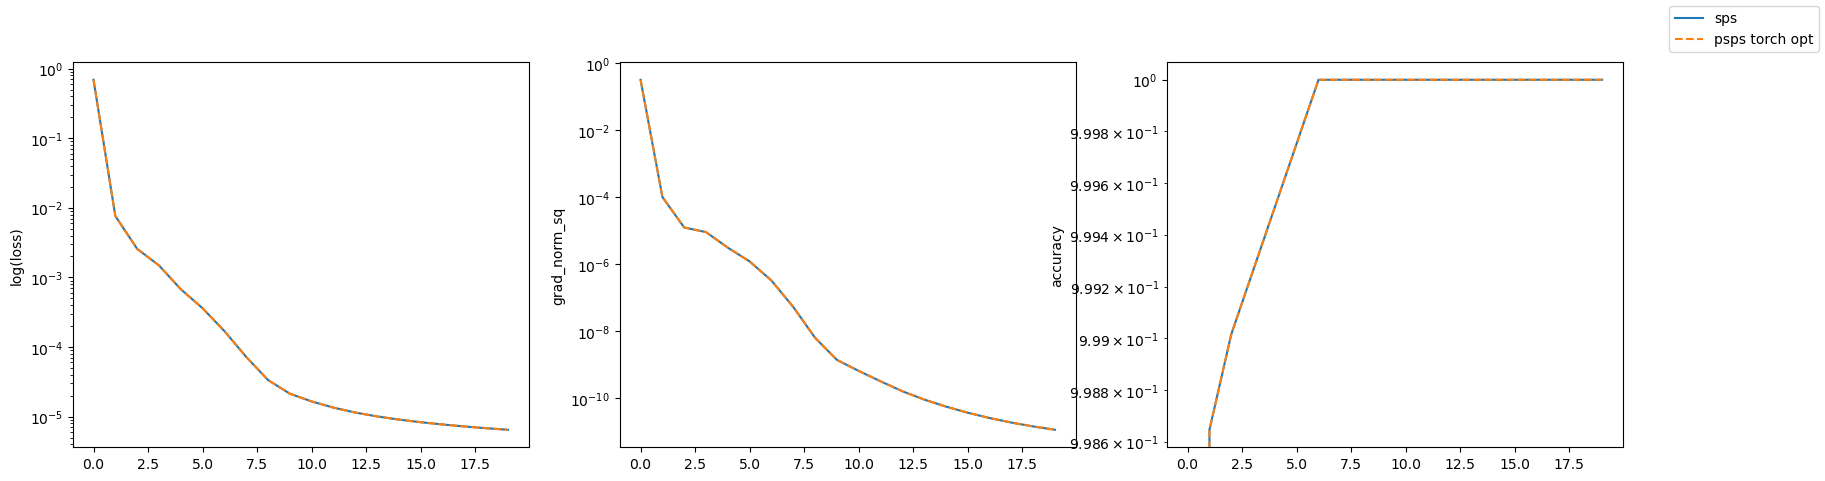

In [419]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=100)

ax[0].semilogy([x[0] for x in hist_sps], label="sps")
ax[0].semilogy([x[0] for x in hist_psps], linestyle="--", label="psps torch opt")

ax[0].set_ylabel("log(loss)")

ax[1].semilogy([x[1] for x in hist_sps])
ax[1].semilogy([x[1] for x in hist_psps], linestyle="--")

ax[1].set_ylabel("grad_norm_sq")

ax[2].semilogy([x[2] for x in hist_sps])
ax[2].semilogy([x[2] for x in hist_psps], linestyle="--")

ax[2].set_ylabel("accuracy")


fig.legend()